# Preamble

In [1]:
include("./parallelPlanner.jl")
include("./GA.jl")
include("./parallelCGA.jl")
include("./plottingUtils.jl")
include("demo_utils.jl")

ma_demo (generic function with 1 method)

# My project 

I am researching the applications of Genetic Algorithms (GAs) on fully autonomous road networks, specifically, *(theoretical)* autonomous motorways

- Self driving cars are becoming more and more prevelant. 
- All currently implemented systems are _selfish_, i.e. each vehicle is only concerned with itself and minimising the travel time of their occupants.
- By taking a higher level view of vehicle routing we can potentially reduce the average travel time, saving more time in total, increasing efficiency of existing road networks.

## Genetic Algorithms

Genetic algorithms are a nature-inspired optimisation technique that mimic the process of evolution on populations of candidate solutions.

# Recap: Single agent planning

In my previous demo I showed my working single-agent planner. 

It was able to:

- Avoid obstacles of circular and rectangular shape
- Avoid leaving the predefined road-space

In [2]:
b1(x) = 0
b2(x) = 10

start_point = Point(0, 5)
goal_point = Point(15, 8)

o1 = Circle(1, Point(15, 5))
o2 = Circle(1.2, Point(2.5, 7))
o3 = Circle(0.8, Point(7, 6))
o4 = Circle(0.8, Point(12, 2))
l = 20
road = Road(b1, b2, [o1, o2, o3, o4], l)

road_plt = draw_road(road, 0, l)
scatter!(
    road_plt,
    [(start_point.x, start_point.y), (goal_point.x, goal_point.y)],
);


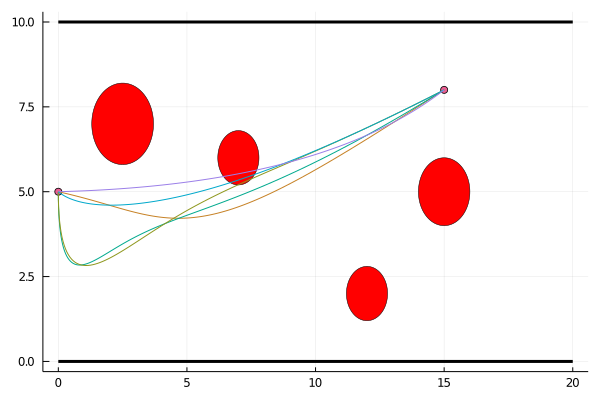

In [3]:
P = GA(
    start_point,
    goal_point,
    road,
    n_gens = 3,
    n = 5,
    selection_method = "roulette",
)
plotGeneration!(road_plt, P)


Below you can see an example of the learning process over the course of 100 generations for a simliar road space problem

![foo](https://sambarrett.online/Y4-Diss/100gens-3.gif)

# Multi-agent planning

I have since expanded this solution to allow for the planning of multiple agents within the same stretch of road. A key factor of this extension is making sure the  routes do not collide. 

How do I differentiate between path intersection (legal) and route collision (illegal)? 

I make an assumption that all agents are travelling at the same constant speed.

The routes are defined as Bezier Curves and as such the position along the route at any time $t$ is given by $B(t)$, I can therefore say that if $\exists t. B_1(t) == B_2(t)$ then routes $B_1$ and $B_2$ collide at some time $t$ Solving this equation however, is not trivial and as such the common approach to finding intersections between two Bezier curves is to approximate the answer via recursive subdivision, still a very computationally expensive procedure


At one point this process alone resulted in a $\approx 50\times$ slowdown! To tackle this issue, I parallelised my `bezInt` function so that it can take advantage of the 16 cores in my system.

`collisionDetection` then wraps this result and works out the lengths of the road segments in which the intersection is detected and derives whether they collide.

In [4]:
b1(x) = 0
b2(x) = 12
l = 20
obstacles = []
road = Road(b1, b2, obstacles, l)
road_plt = draw_road(road, 0, l);


In [5]:
starts = [Point(0, 5), Point(0, 8), Point(0, 6)]

goals = [Point(20, 8), Point(18, 3), Point(15, 5)]

n=6 # size of population
ng=2 # number of generations


P = PCGA(
    starts,
    goals,
    road,
    n_gens = ng,
    n = n,
    selection_method = "roulette",
    mutation_method = "gaussian",
)



3-element Array{Individual,1}:
 Individual(Phenotype(Point(0, 5), Point[Point(0, 5), Point(2.966666666666667, 5.0), Point(8.333333333333332, 5.5), Point(14.299999999999999, 6.0), Point(20, 8)], Point(20, 8)), 20.331149467910464)
 Individual(Phenotype(Point(0, 8), Point[Point(0, 8), Point(11.9, 3), Point(18, 3)], Point(18, 3)), 18.844645651242097)
 Individual(Phenotype(Point(0, 6), Point[Point(0, 6), Point(10.55, 5), Point(15, 5)], Point(15, 5)), 15.040291883567122)

┌ Info: Saved animation to 
│   fn = /home/sam/git-clones/Y4-Diss/code/julia/src/anim1.gif
└ @ Plots /home/sam/.julia/packages/Plots/SjqWU/src/animation.jl:104


Plots.AnimatedGif("/home/sam/git-clones/Y4-Diss/code/julia/src/anim1.gif")
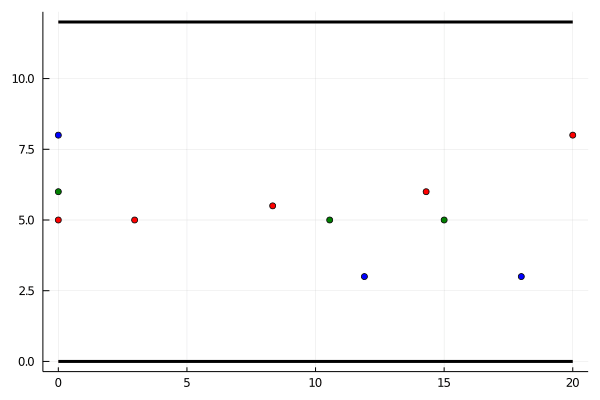

In [6]:
plot_generation_gif(road,P)

In [21]:
any_collisions = collisionDetection(P[1],P[2]) || collisionDetection(P[1],P[3]) ||  collisionDetection(P[3],P[2])

false

# Macro level route planning

Planning routes for vehicles is not just about routing a single set of vehicles through a set section of road. There is a bigger picture: a interconnected network of roads with vehicles traversing multiple different sections of road to get from $A \rightarrow B$ 

To implement this, I used a graphing library in which I can attach metadata to edges. The metadata I chose to attach was the `Road` structure I have been using for my micro-level planning. I can then perform Dijkstra's algorithm on this road network, weighting each edge with the `Road.length` attribute. 

Each agent can then be assigned a series of road segments it must traverse in order to reach it's global goal position.

In [8]:
desired_paths = [
    (1,4),
    (4,2),
    (1,4),
    (3,5)
]

4-element Array{Tuple{Int64,Int64},1}:
 (1, 4)
 (4, 2)
 (1, 4)
 (3, 5)

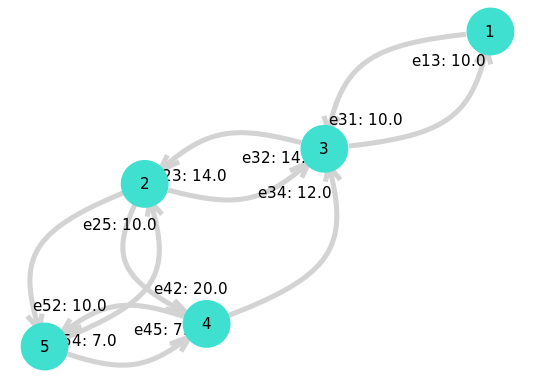

In [9]:
include("demoRoadNetwork.jl")

In [22]:
plans = planRoutes(desired_paths, rn);

macroPath = [1, 3, 2, 5, 4]
macroPath = [4, 5, 2]
macroPath = [1, 3, 2, 5, 4]
macroPath = [3, 2, 5]


In [11]:
start = plans[1][1].phenotype.genotype[1]
goal = plans[1][1].phenotype.genotype[end]
(plans[1][1].fitness / √((start.x - goal.x)^2 +(start.y - goal.y)^2))<1.1


true

In [12]:
n =1
while n < 10
    n |> println 
    if n > 5
        break
    end
    n = n +1
end


1
2
3
4
5
6


When planning these routes it is necessary to be aware of which agents are on the same road at the same time. 

Just becuase the path for agent $A$ is $1 \rightarrow 2 \rightarrow 3$ and $B$ is $4\rightarrow 2 \rightarrow 3$ doesn't necessarily mean that when planning we must consider both. 

However if $len(e12) \leq len(e23)$ then they **will** share the edge $e23$ and the planning must take this into account. Otherwise if $len(e12) > len(e23)$ then agent $B$ will have left the edge before $A$ enters.

In [13]:
plts = plot_road_network(plans, rn, desired_paths)

┌ Info: Saved animation to 
│   fn = /home/sam/git-clones/Y4-Diss/code/julia/src/anim0.gif
└ @ Plots /home/sam/.julia/packages/Plots/SjqWU/src/animation.jl:104
┌ Info: Saved animation to 
│   fn = /home/sam/git-clones/Y4-Diss/code/julia/src/anim1.gif
└ @ Plots /home/sam/.julia/packages/Plots/SjqWU/src/animation.jl:104
┌ Info: Saved animation to 
│   fn = /home/sam/git-clones/Y4-Diss/code/julia/src/anim2.gif
└ @ Plots /home/sam/.julia/packages/Plots/SjqWU/src/animation.jl:104
┌ Info: Saved animation to 
│   fn = /home/sam/git-clones/Y4-Diss/code/julia/src/anim3.gif
└ @ Plots /home/sam/.julia/packages/Plots/SjqWU/src/animation.jl:104
┌ Info: Saved animation to 
│   fn = /home/sam/git-clones/Y4-Diss/code/julia/src/anim4.gif
└ @ Plots /home/sam/.julia/packages/Plots/SjqWU/src/animation.jl:104
┌ Info: Saved animation to 
│   fn = /home/sam/git-clones/Y4-Diss/code/julia/src/anim5.gif
└ @ Plots /home/sam/.julia/packages/Plots/SjqWU/src/animation.jl:104


6-element Array{Any,1}:
 Plots.AnimatedGif("/home/sam/git-clones/Y4-Diss/code/julia/src/anim0.gif")
 Plots.AnimatedGif("/home/sam/git-clones/Y4-Diss/code/julia/src/anim1.gif")
 Plots.AnimatedGif("/home/sam/git-clones/Y4-Diss/code/julia/src/anim2.gif")
 Plots.AnimatedGif("/home/sam/git-clones/Y4-Diss/code/julia/src/anim3.gif")
 Plots.AnimatedGif("/home/sam/git-clones/Y4-Diss/code/julia/src/anim4.gif")
 Plots.AnimatedGif("/home/sam/git-clones/Y4-Diss/code/julia/src/anim5.gif")

In [14]:
    macroPaths = map(i -> macroPath(rn, i[1],i[2]), desired_paths)
    pathGroups = getPathGroups(rn,desired_paths, macroPaths)


Dict{Any,Any} with 6 entries:
  (2, 5) => [4, 1, 3]
  (3, 2) => [4, 1, 3]
  (5, 2) => [2]
  (5, 4) => [3, 1]
  (1, 3) => [3, 1]
  (4, 5) => [2]

Two of these routes should be staggered compared with the other as the _enter_ the road later. This has proved difficult to visualise 

Edge $e25$ from the graph will have these routes passing through it:

Plots.AnimatedGif("/home/sam/git-clones/Y4-Diss/code/julia/src/anim0.gif")
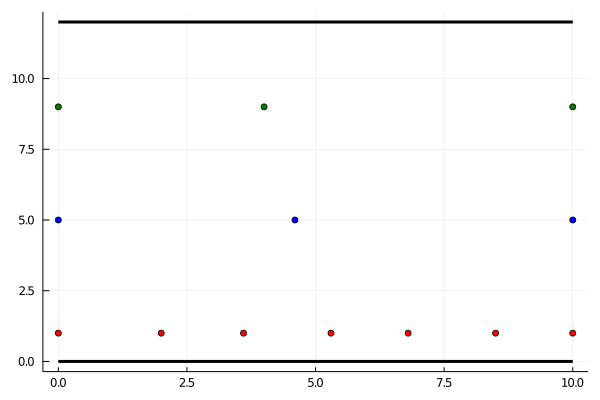

In [15]:
plts[1]

## Edge $e32$ 

Plots.AnimatedGif("/home/sam/git-clones/Y4-Diss/code/julia/src/anim1.gif")
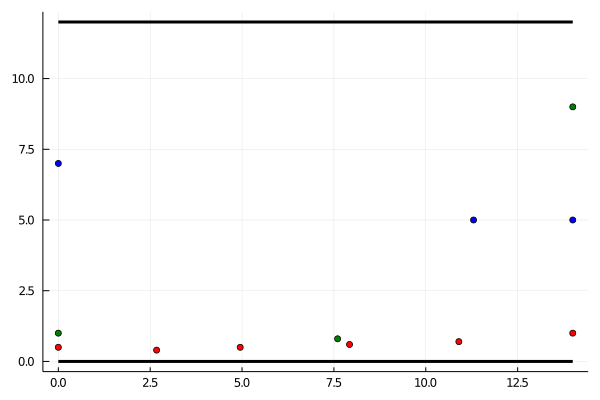

In [16]:
plts[2]

## Edge $e52$ 

Plots.AnimatedGif("/home/sam/git-clones/Y4-Diss/code/julia/src/anim2.gif")
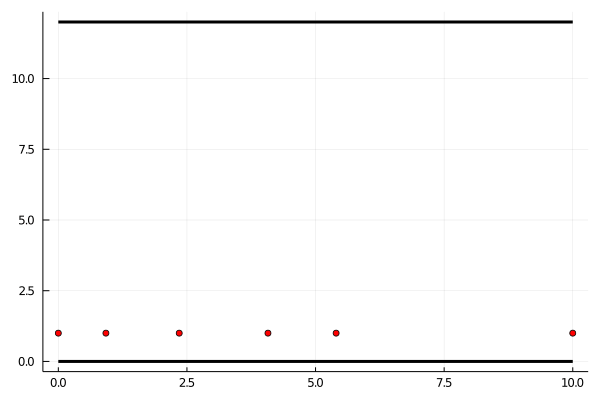

In [17]:
plts[3]

## Edge $e54$ 

Plots.AnimatedGif("/home/sam/git-clones/Y4-Diss/code/julia/src/anim3.gif")
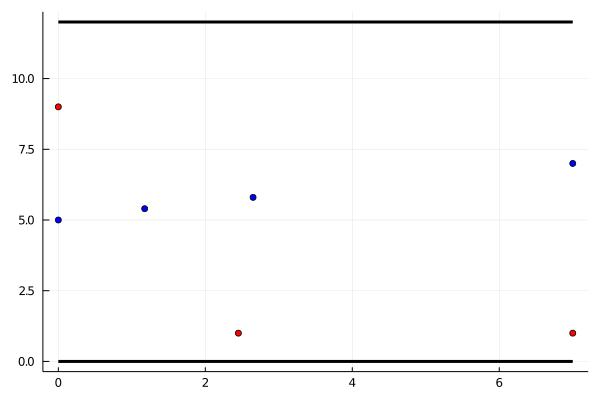

In [18]:
plts[4]

## Edge $e13$ 

Plots.AnimatedGif("/home/sam/git-clones/Y4-Diss/code/julia/src/anim4.gif")
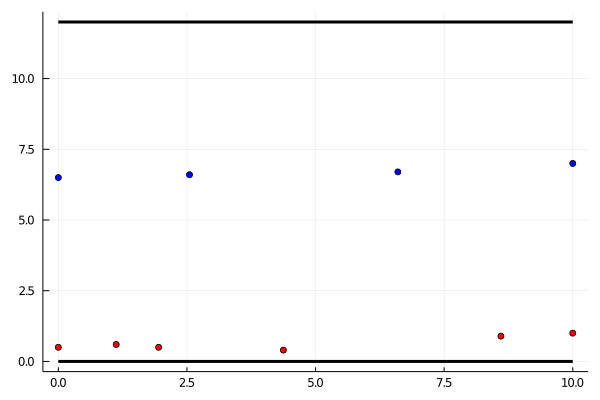

In [19]:
plts[5]

## Edge $e45$

Plots.AnimatedGif("/home/sam/git-clones/Y4-Diss/code/julia/src/anim5.gif")
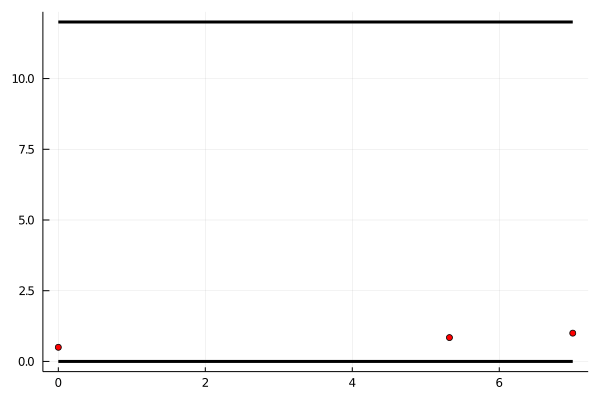

In [20]:
plts[6]